## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from IPython.display import clear_output

from models.rvae import RVAE

print('imported')

imported


## Constants

In [2]:
np.random.seed(42)

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

WEIGHTS_DIR = './weights'

BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 100
IN_CHANNELS = 1
LATENT_DIM = 2
IMG_SIZE = (28, 28)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


## MNIST Data preprocess

In [3]:
# dans un premier lieu, nous allons travailler avec MNIST
mnist = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True)

n_samples = 1000

# removing some digits to reduce the size of the dataset
selected_index = np.isin(mnist.targets, [1, 2, 3])
images = mnist.data[selected_index][:n_samples]
targets = mnist.targets[selected_index][:n_samples]

# preprocessing
images = images.__div__(255).type(torch.float32)# .reshape(-1, 28 * 28)
images = images.unsqueeze(1)

train_x, test_x, train_y, test_y = train_test_split(images, targets, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=BATCH_SIZE, shuffle=False)

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, transform=None):
        self.x = x
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx])
        return self.x[idx]

print('Number of training samples: {}'.format(len(train_x)))
print('Number of test samples: {}'.format(len(test_x)))
print('Number of iterations per epoch: {}'.format(len(train_loader)))
print('Image size: {}'.format(train_x.shape))

Number of training samples: 900
Number of test samples: 100
Number of iterations per epoch: 15
Image size: torch.Size([900, 1, 28, 28])


## Poly LR Scheduler

In [4]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = LEARNING_RATE / 10
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

## Training

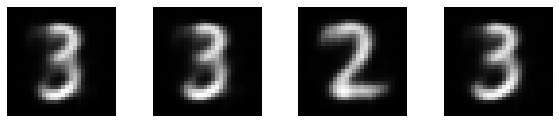

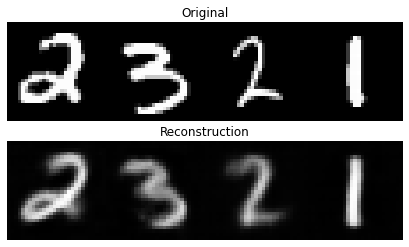

Epoch:    91/100 - Loss: 28.6216 - Recon Loss: 24.5769 - KL Loss: 4.0447: 100%|██████████| 14/14 [00:00<00:00, 18.66it/s]
Epoch:    92/100 - Loss: 28.7653 - Recon Loss: 24.7115 - KL Loss: 4.0538: 100%|██████████| 14/14 [00:00<00:00, 29.46it/s]
Epoch:    93/100 - Loss: 28.2538 - Recon Loss: 24.2626 - KL Loss: 3.9912: 100%|██████████| 14/14 [00:00<00:00, 27.67it/s]
Epoch:    94/100 - Loss: 28.3581 - Recon Loss: 24.3741 - KL Loss: 3.9841: 100%|██████████| 14/14 [00:00<00:00, 26.90it/s]
Epoch:    95/100 - Loss: 28.8893 - Recon Loss: 24.9213 - KL Loss: 3.9680: 100%|██████████| 14/14 [00:00<00:00, 27.44it/s]
Epoch:    96/100 - Loss: 28.2410 - Recon Loss: 24.2104 - KL Loss: 4.0306: 100%|██████████| 14/14 [00:00<00:00, 27.35it/s]
Epoch:    97/100 - Loss: 28.3177 - Recon Loss: 24.3255 - KL Loss: 3.9921: 100%|██████████| 14/14 [00:00<00:00, 27.28it/s]
Epoch:    98/100 - Loss: 28.0980 - Recon Loss: 24.0199 - KL Loss: 4.0781: 100%|██████████| 14/14 [00:00<00:00, 26.39it/s]
Epoch:    99/100 - Loss:

Training over


In [5]:
verbose = True

# model
model = RVAE(
    input_shape=(IN_CHANNELS, *IMG_SIZE), out_channels=1, latent_dim=LATENT_DIM,
    hidden_channels=[64, 128, 128, 256, 256], dt=0.1, skip=False
).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# data loader
train_loader = torch.utils.data.DataLoader(IdentityDataset(train_x), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:#, 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x) in enumerate(dataloader):
            x = x.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                recon_x, z, eps, mu, log_var, _ = model(x)
                loss, recon_loss, kl_loss = model.loss_function(recon_x, x, mu, log_var)
                if phase == 'train':
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
                    optimizer.step()
                    # scheduler.step()

            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Loss: {:.4f} - Recon Loss: {:.4f} - KL Loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, running_loss / (i + 1), running_recon_loss / (i + 1), running_kl_loss / (i + 1)
                    ))

        epoch_loss = running_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if epoch % 10 == 0:
            # cleaning output
            clear_output(wait=True)
            
            # plotting generation
            model.eval()
            n_sample = 4
            sample = model.sample(n_sample, 1)
            sample = sample.view(n_sample, 28, 28)
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.axis('off')
                plt.imshow(sample[i].detach().cpu().reshape(28, 28), cmap='gray')
            plt.show()

            # plotting reconstruction
            x = torch.hstack([img for img in x[:n_sample].view(n_sample, 28, 28)])
            recon_x = torch.hstack([img for img in recon_x[:n_sample].view(n_sample, 28, 28)])
            plt.figure(figsize=(20, 4))
            plt.subplot(2, 1, 1)
            plt.axis('off')
            plt.title('Original')
            plt.imshow(torchvision.utils.make_grid(x, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.subplot(2, 1, 2)
            plt.axis('off')
            plt.title('Reconstruction')
            plt.imshow(torchvision.utils.make_grid(recon_x, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.show()

        if verbose: progress.close()
        del progress

print('Training over')

### Saving model

In [ ]:
torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, 'rvae_1000epochs.pth'))
print('saved')

saved


## All data

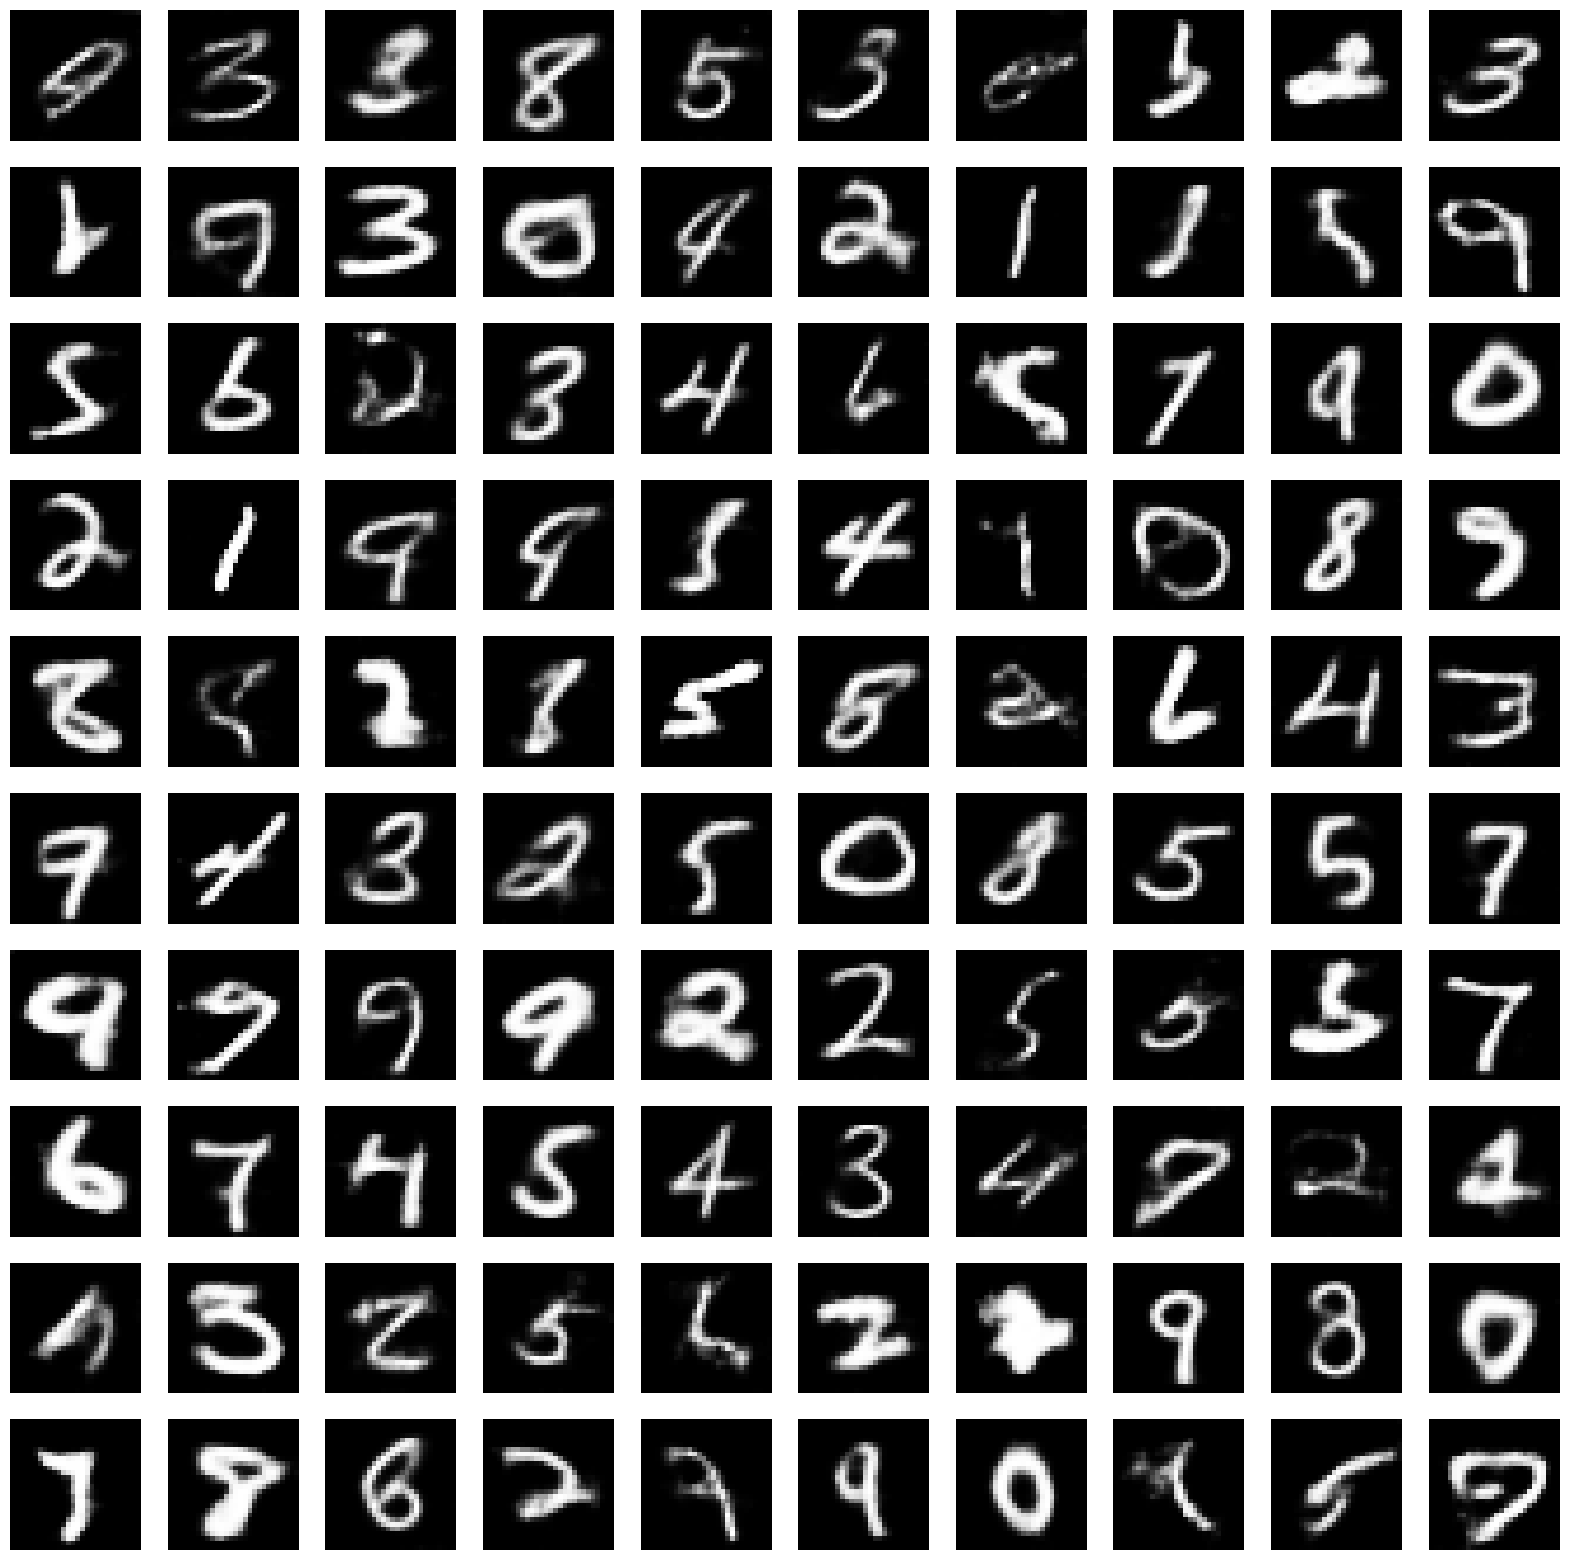

In [212]:
model.eval()
recons = model.sample(100, 1.5)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

## DIM = 10 ~ Gaussienne 1.5

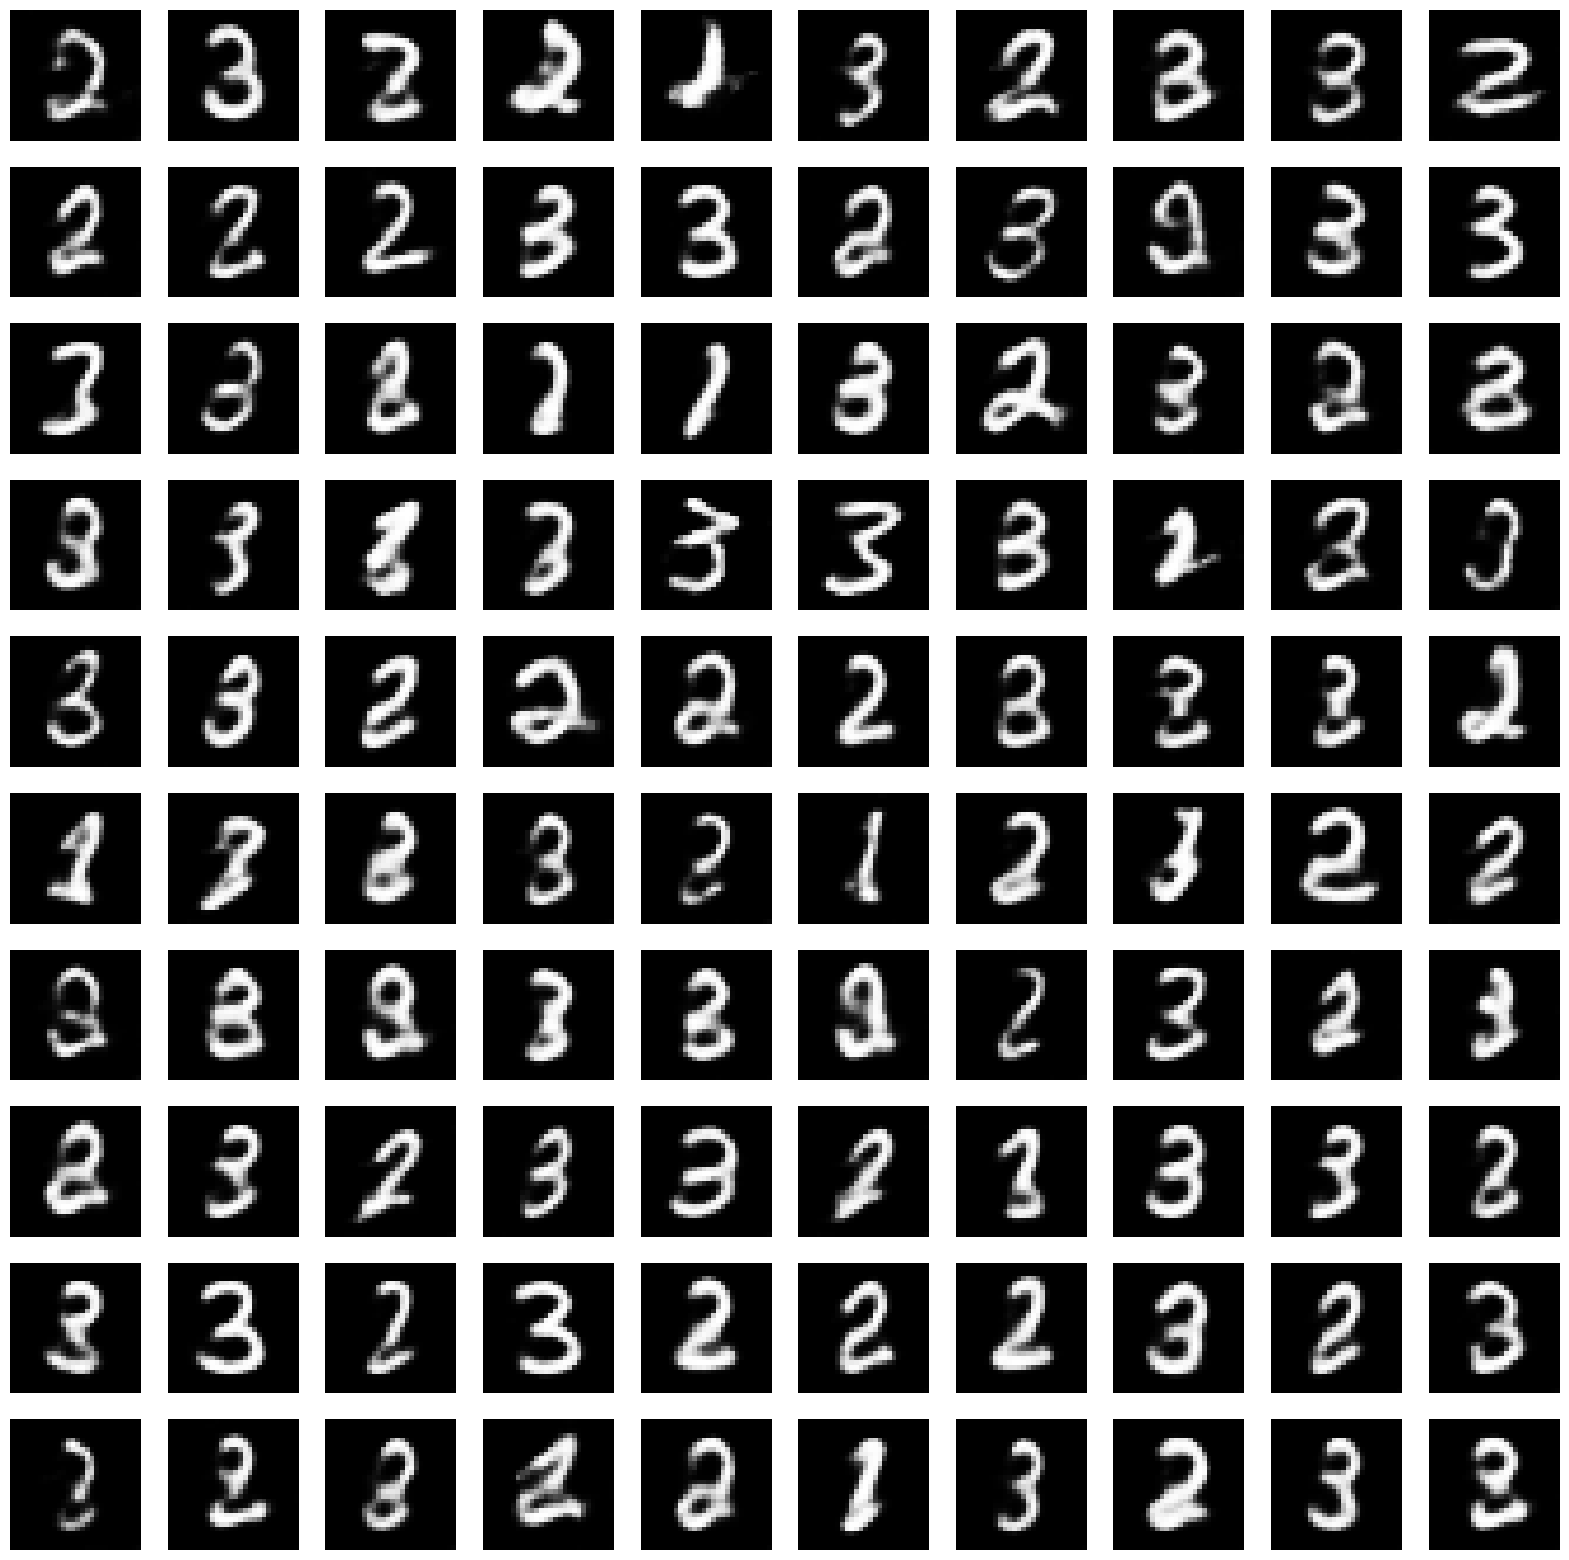

In [198]:
model.eval()
recons = model.sample(100, 1.5)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

## DIM = 2

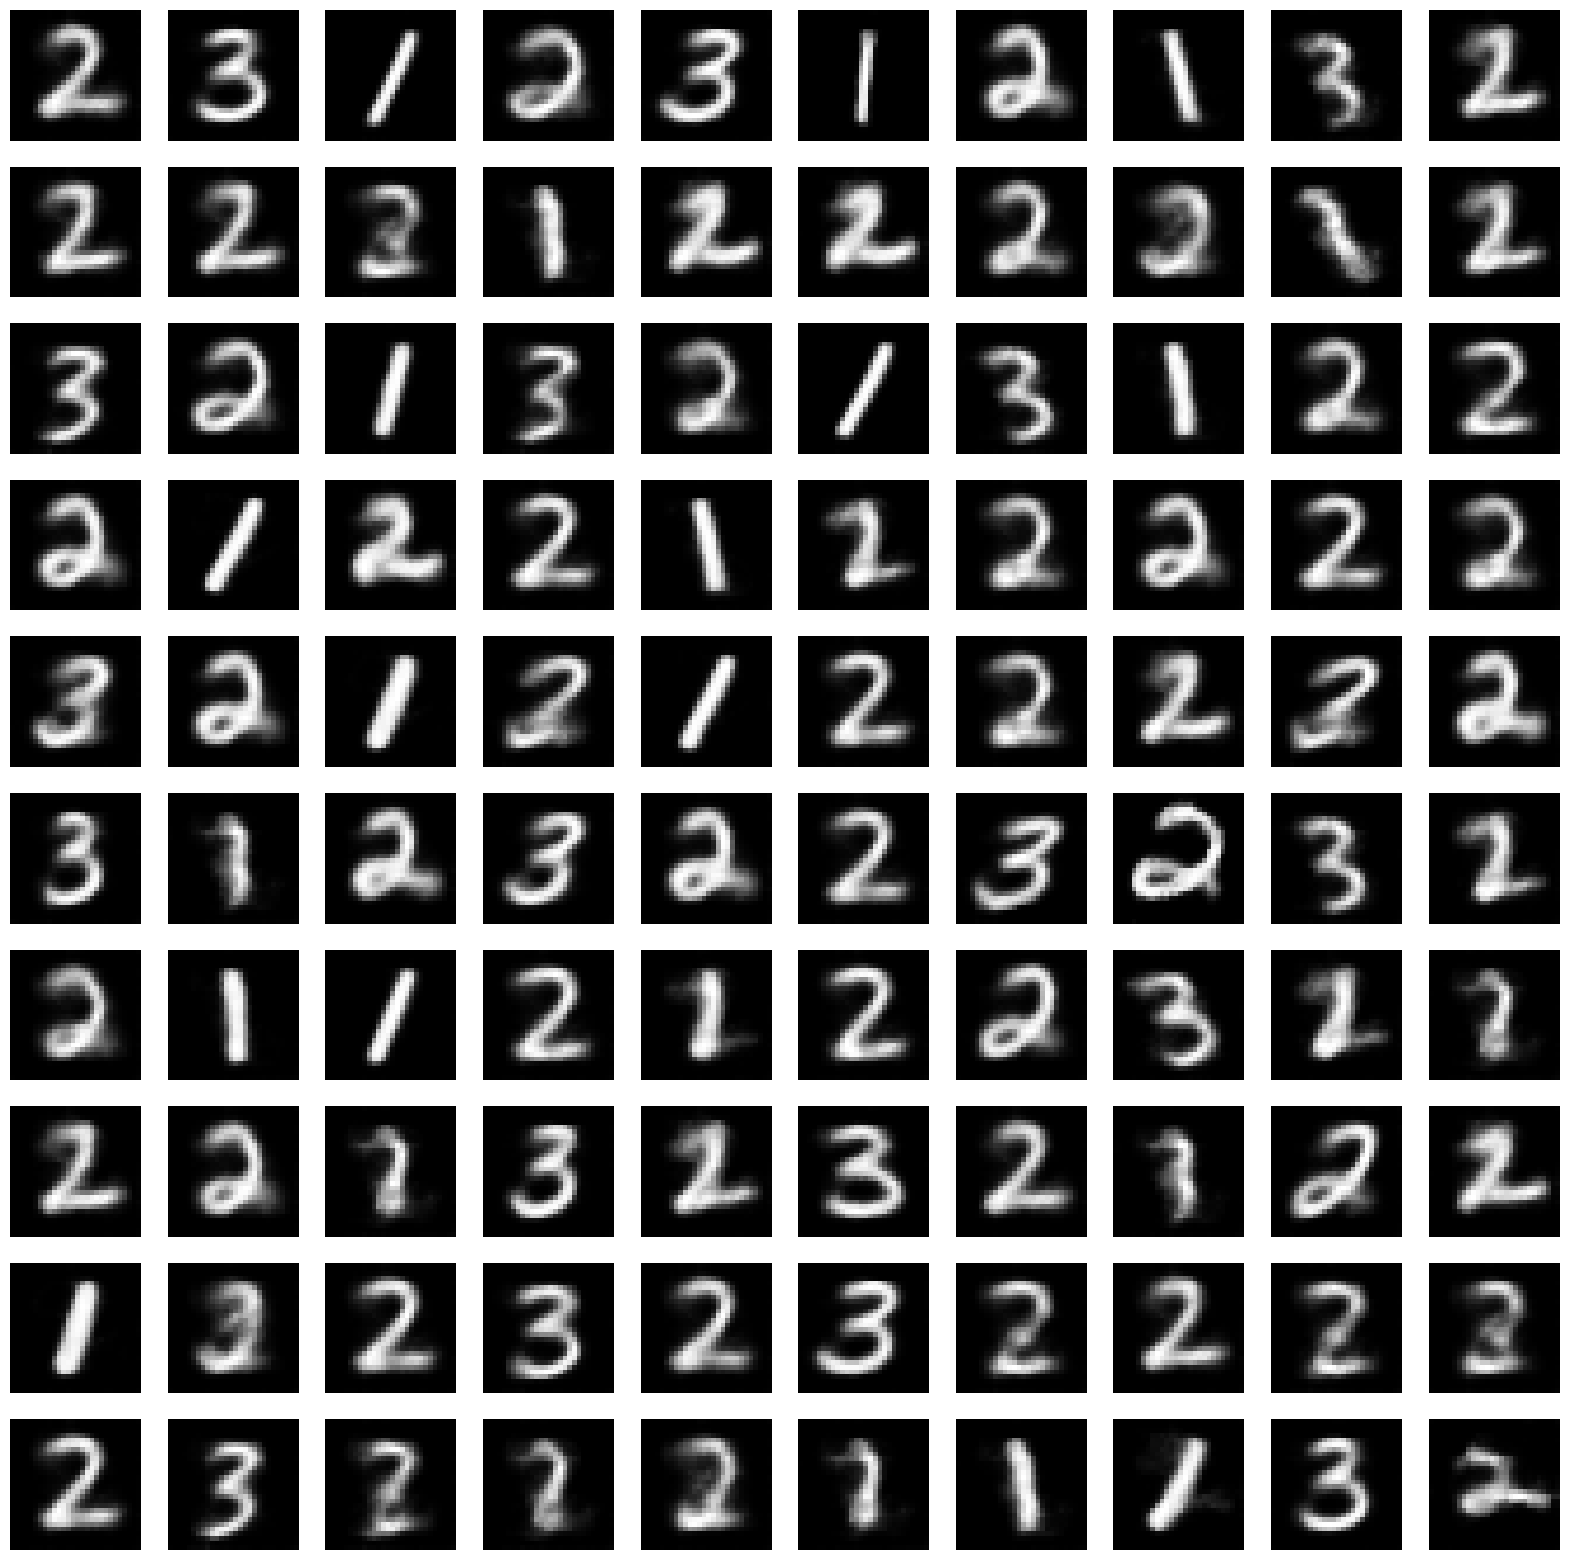

In [176]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

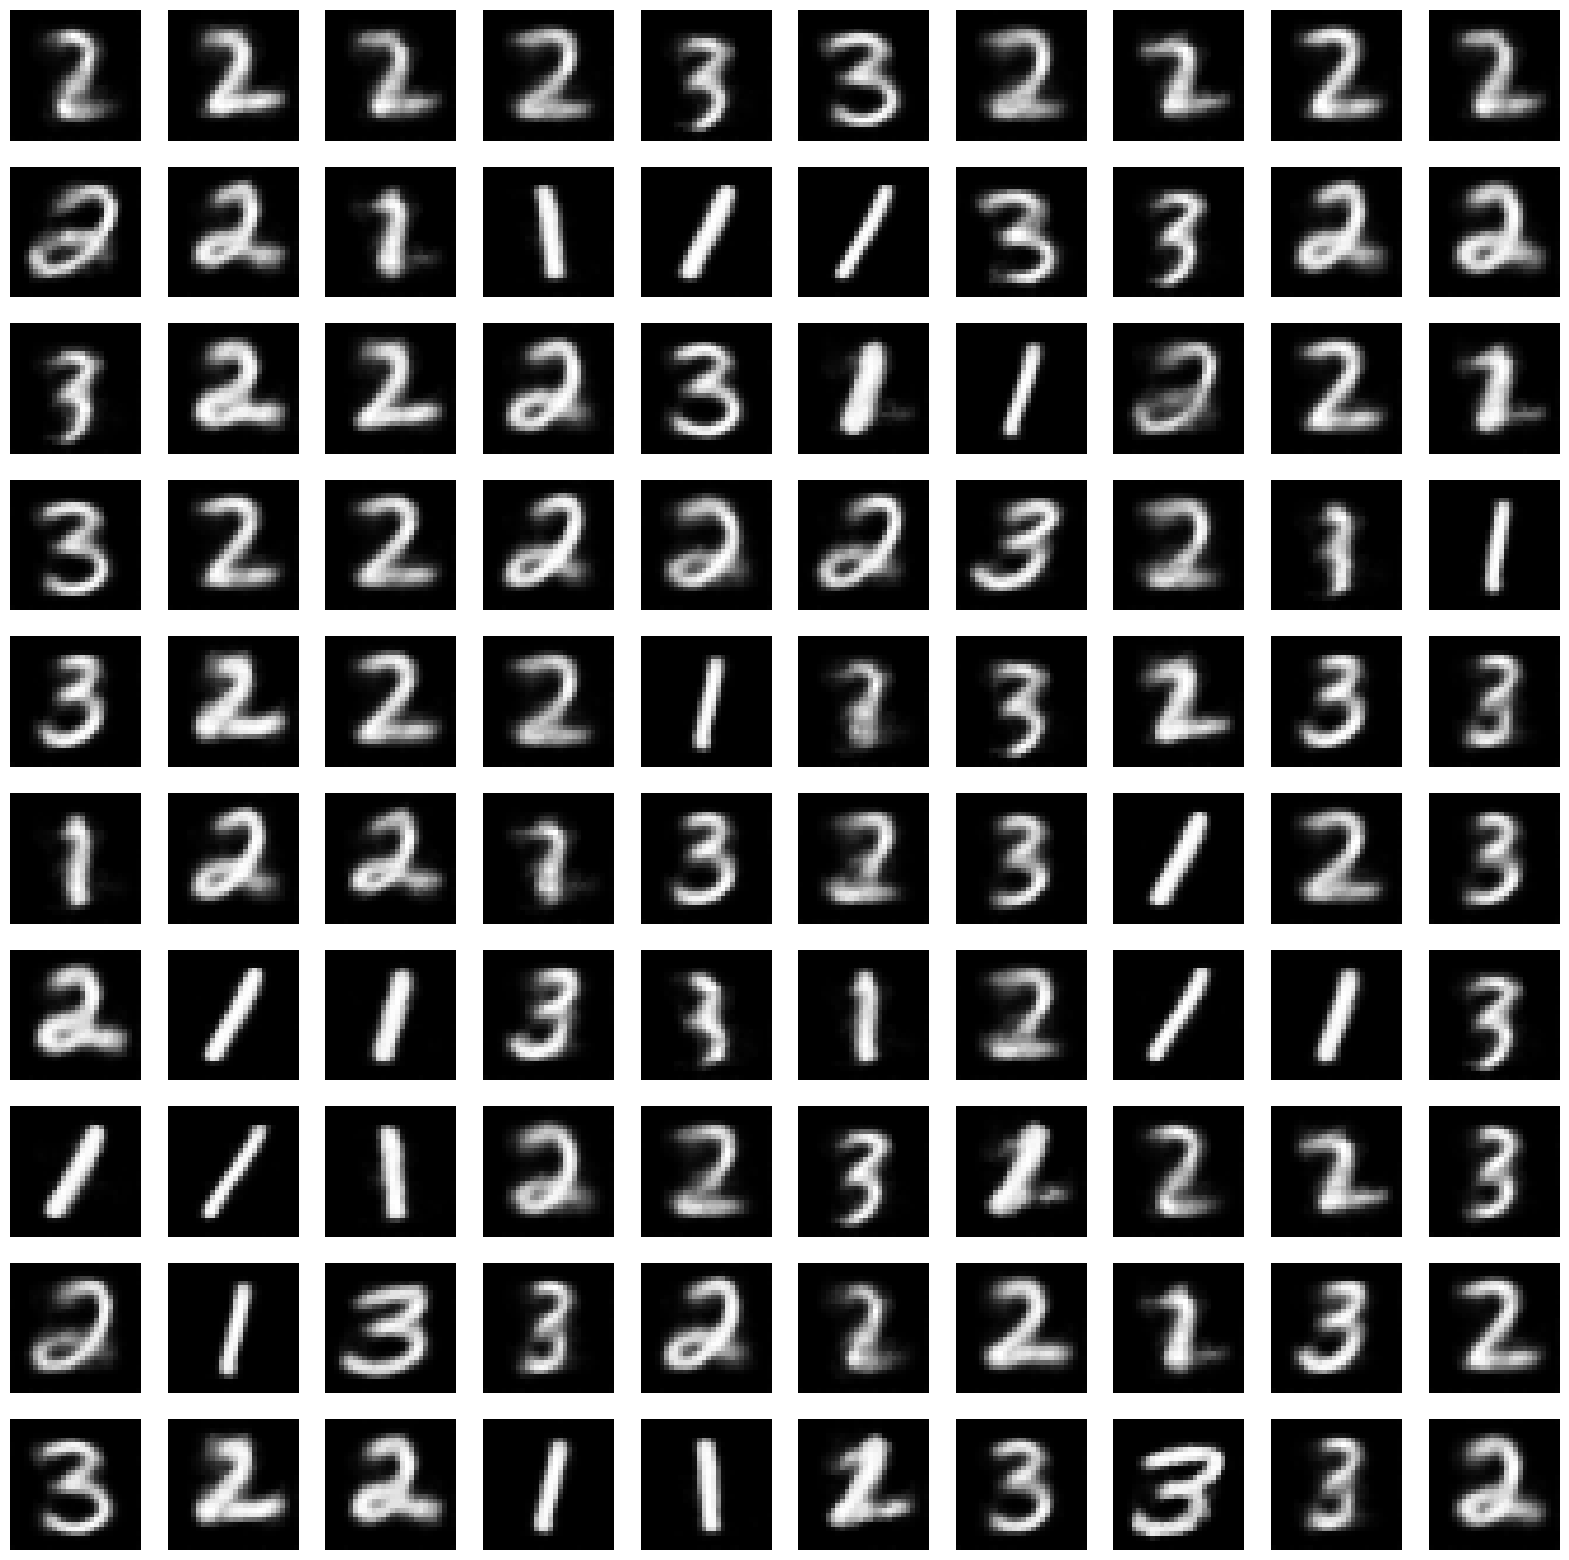

In [168]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

## DIM = 8

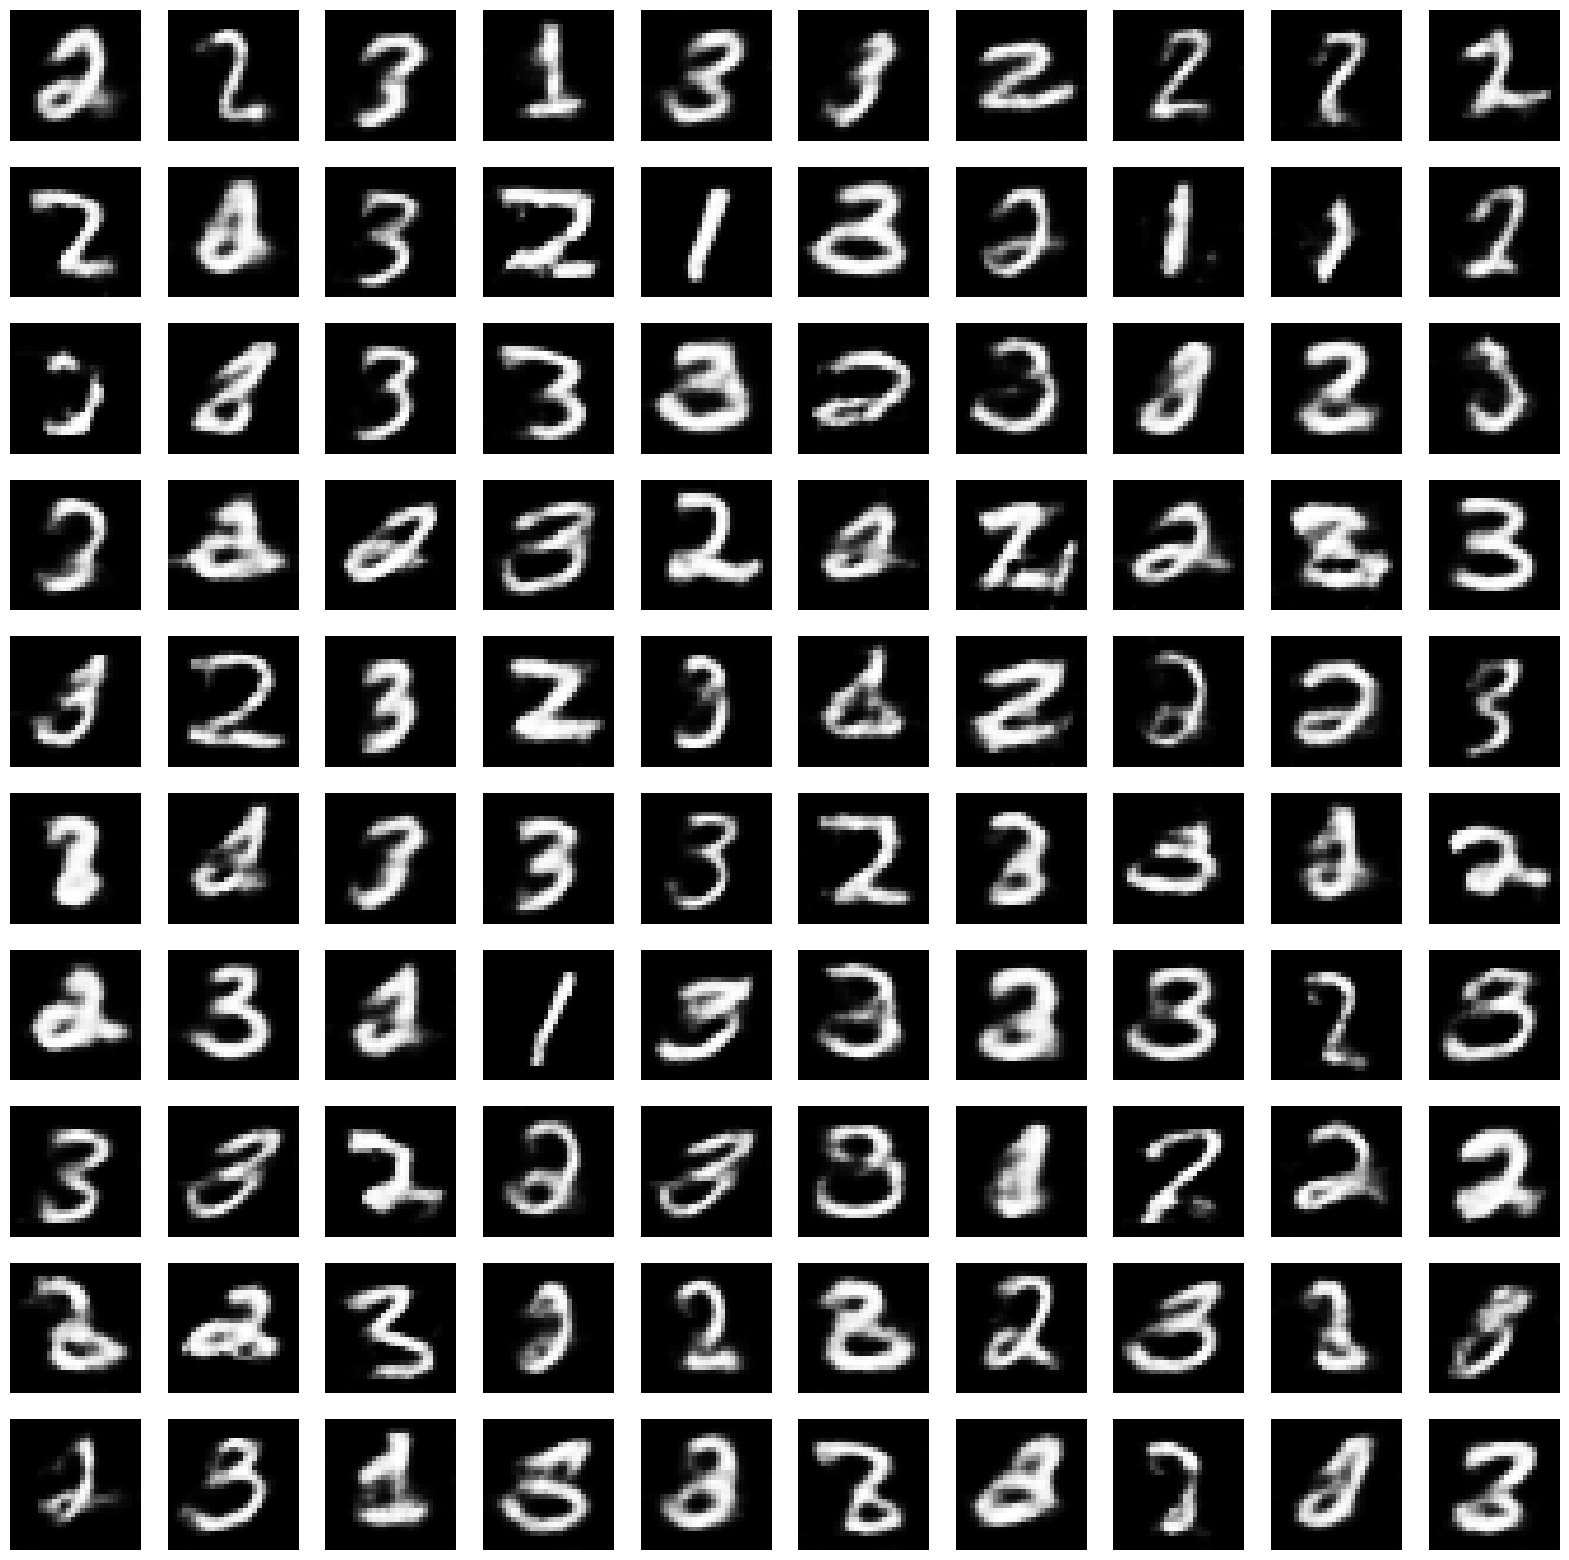

In [190]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

## DIM = 16

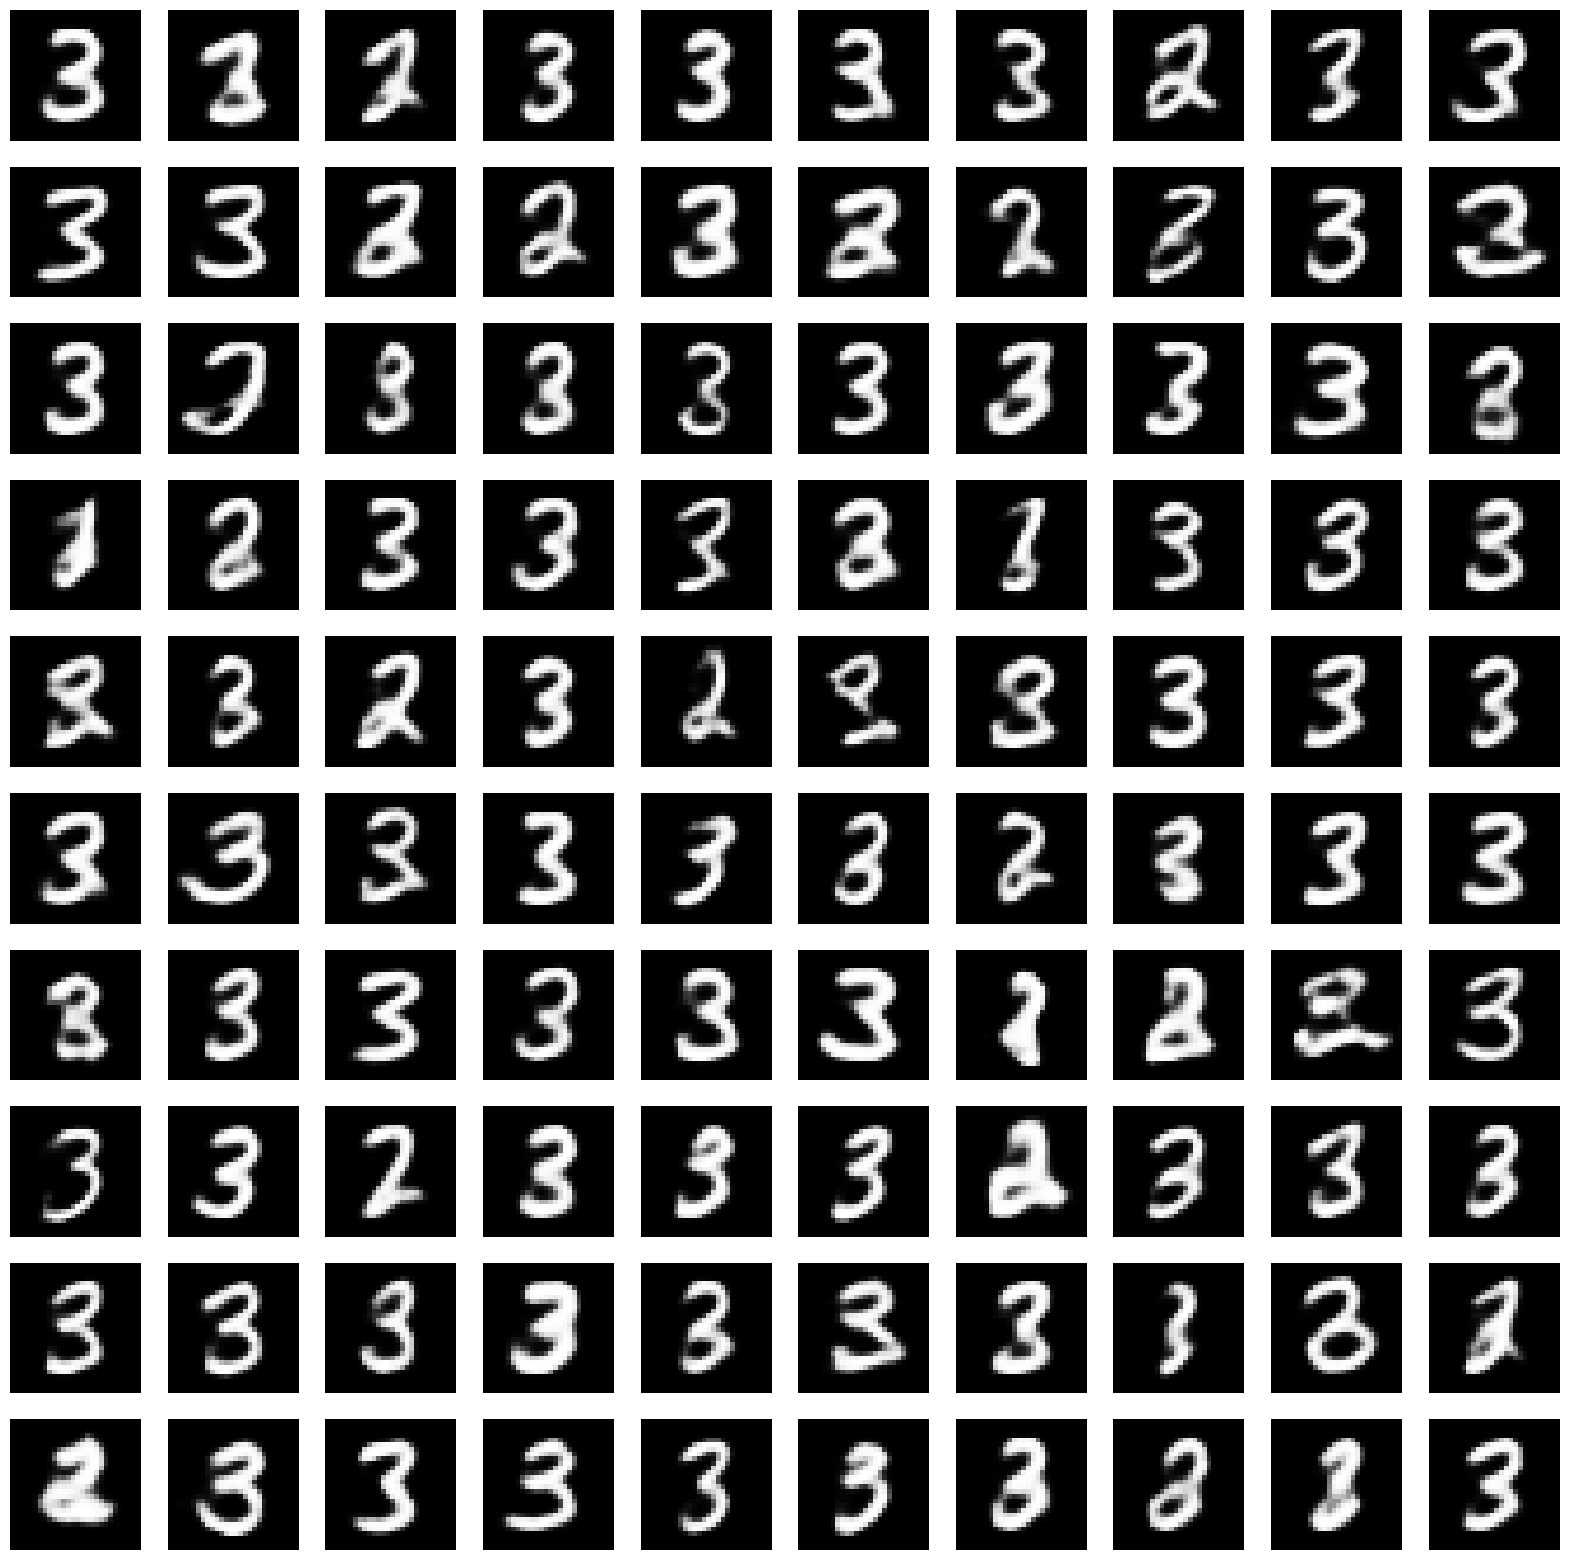

In [135]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

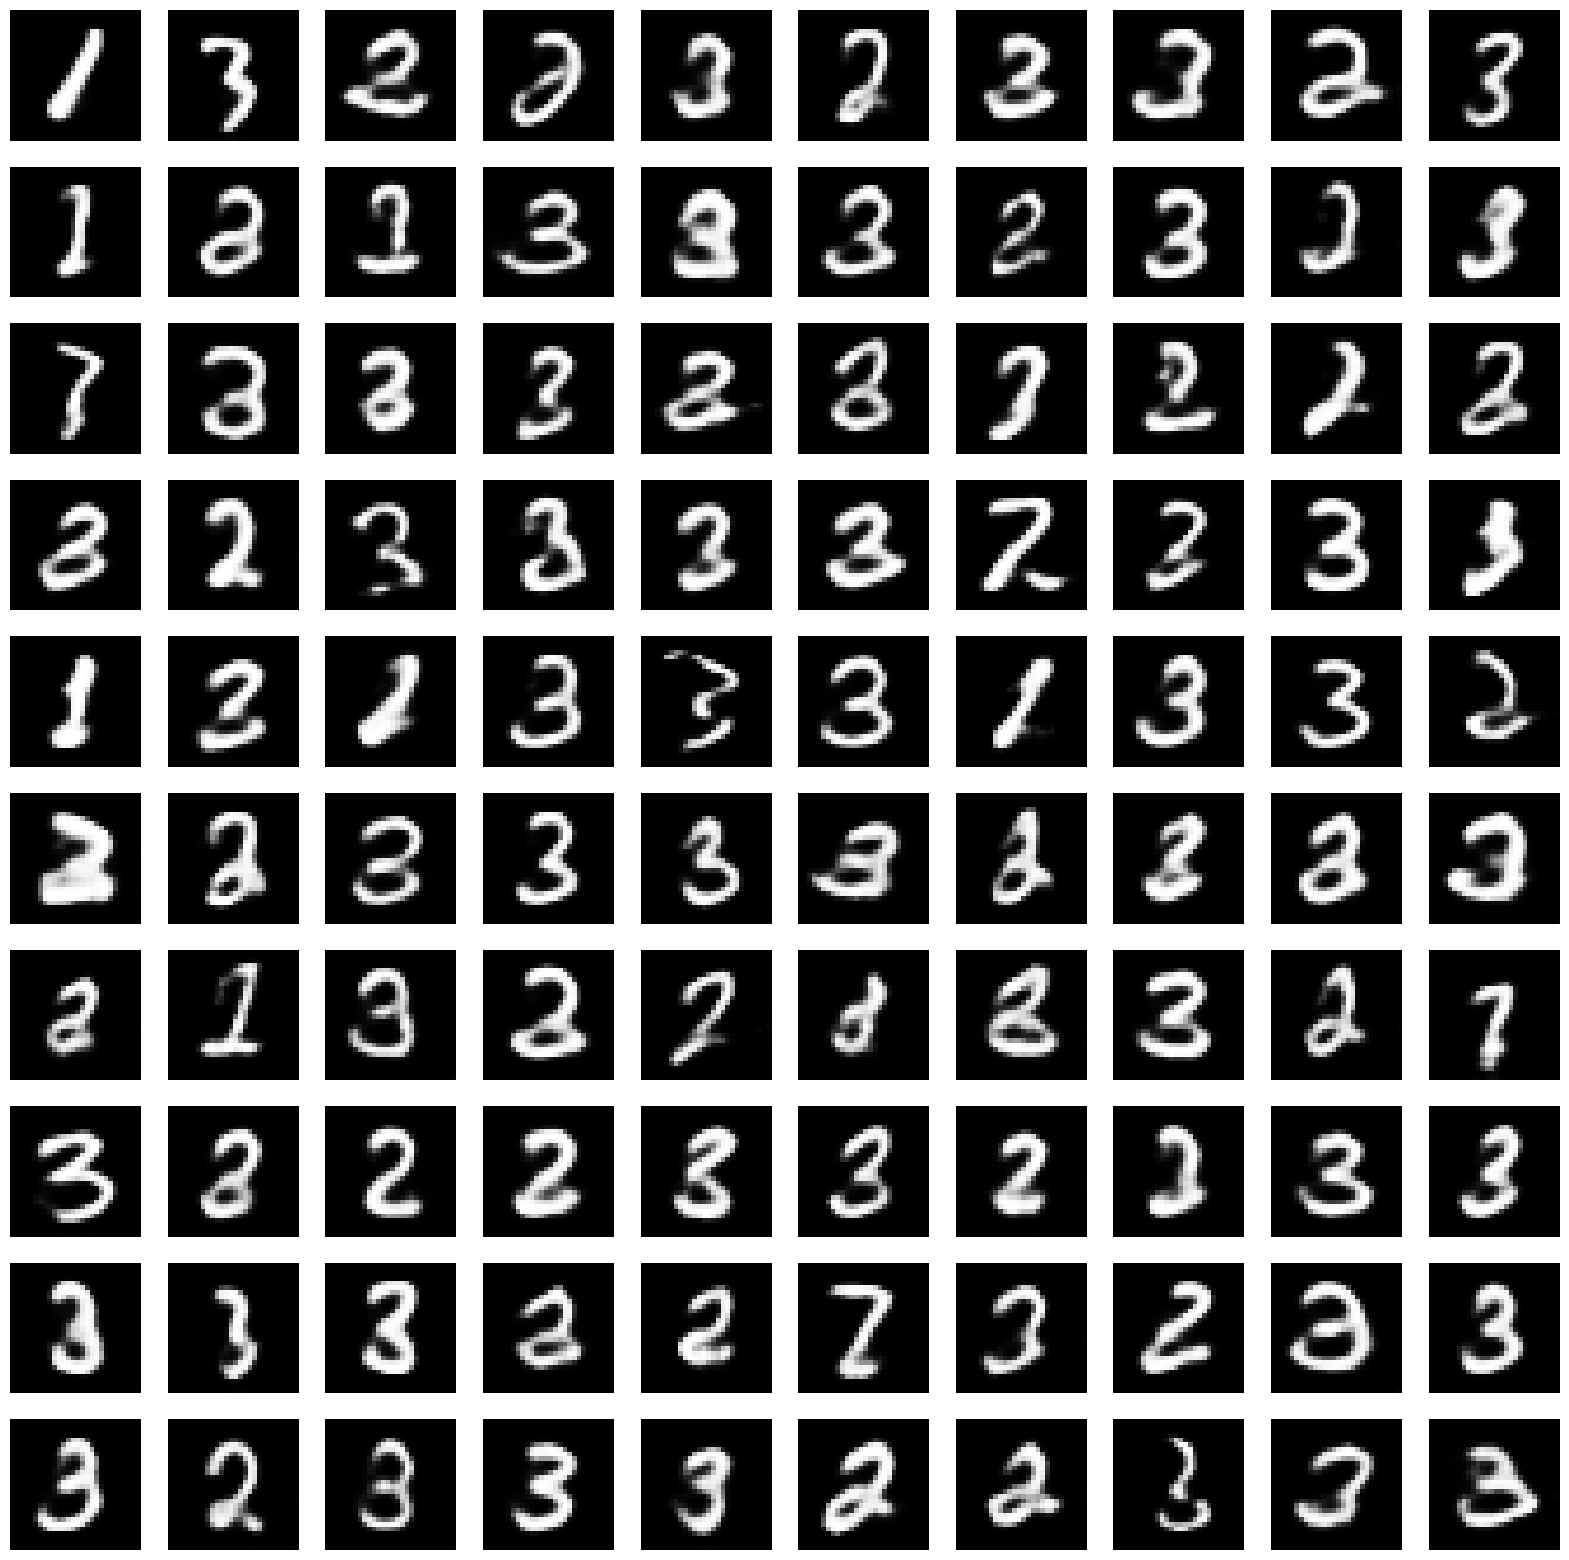

In [119]:
model.eval()
recons = model.sample(100)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

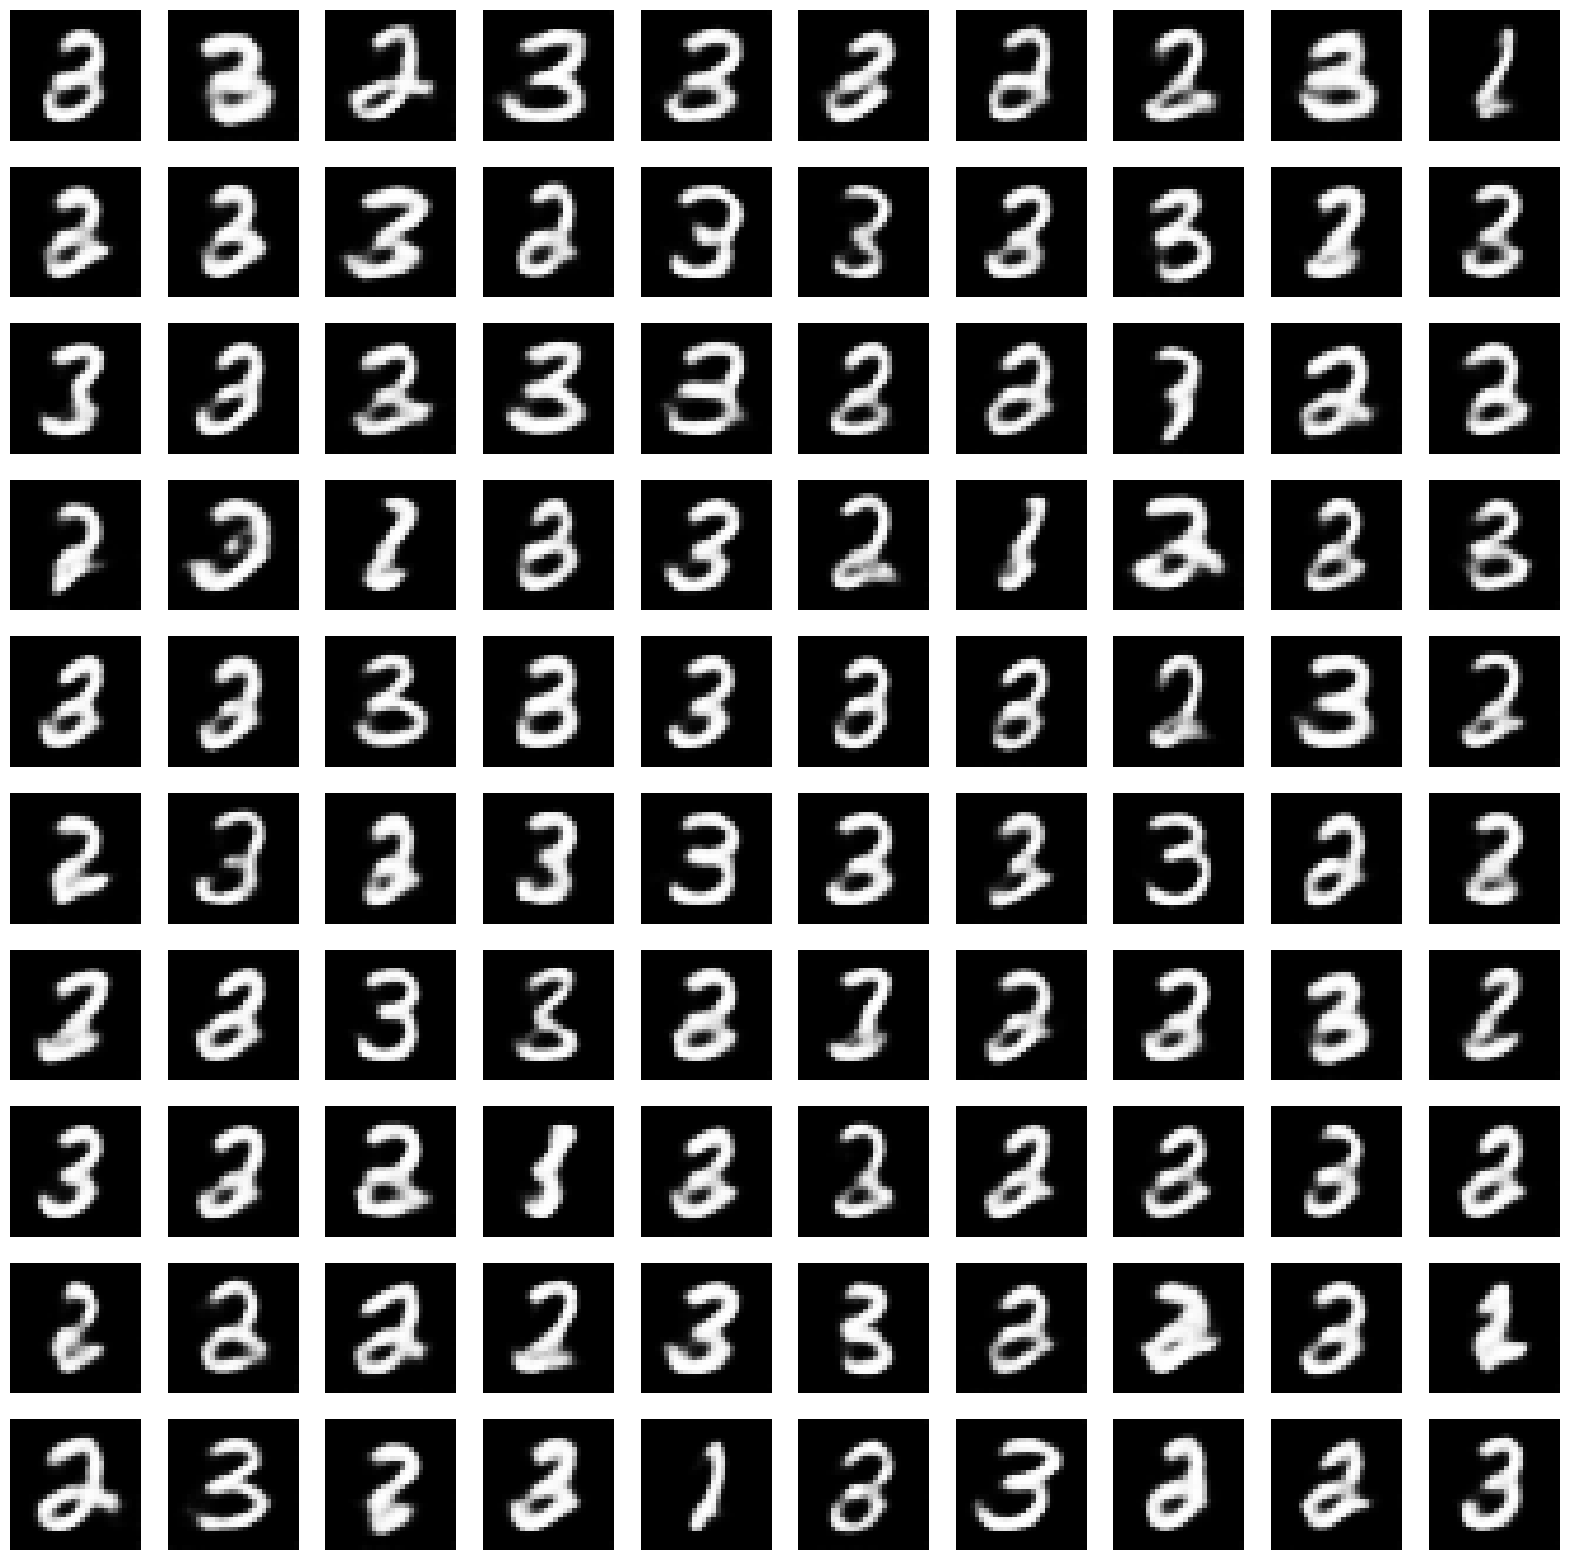

In [114]:
model.eval()
recons = model.sample(100)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

## VAE

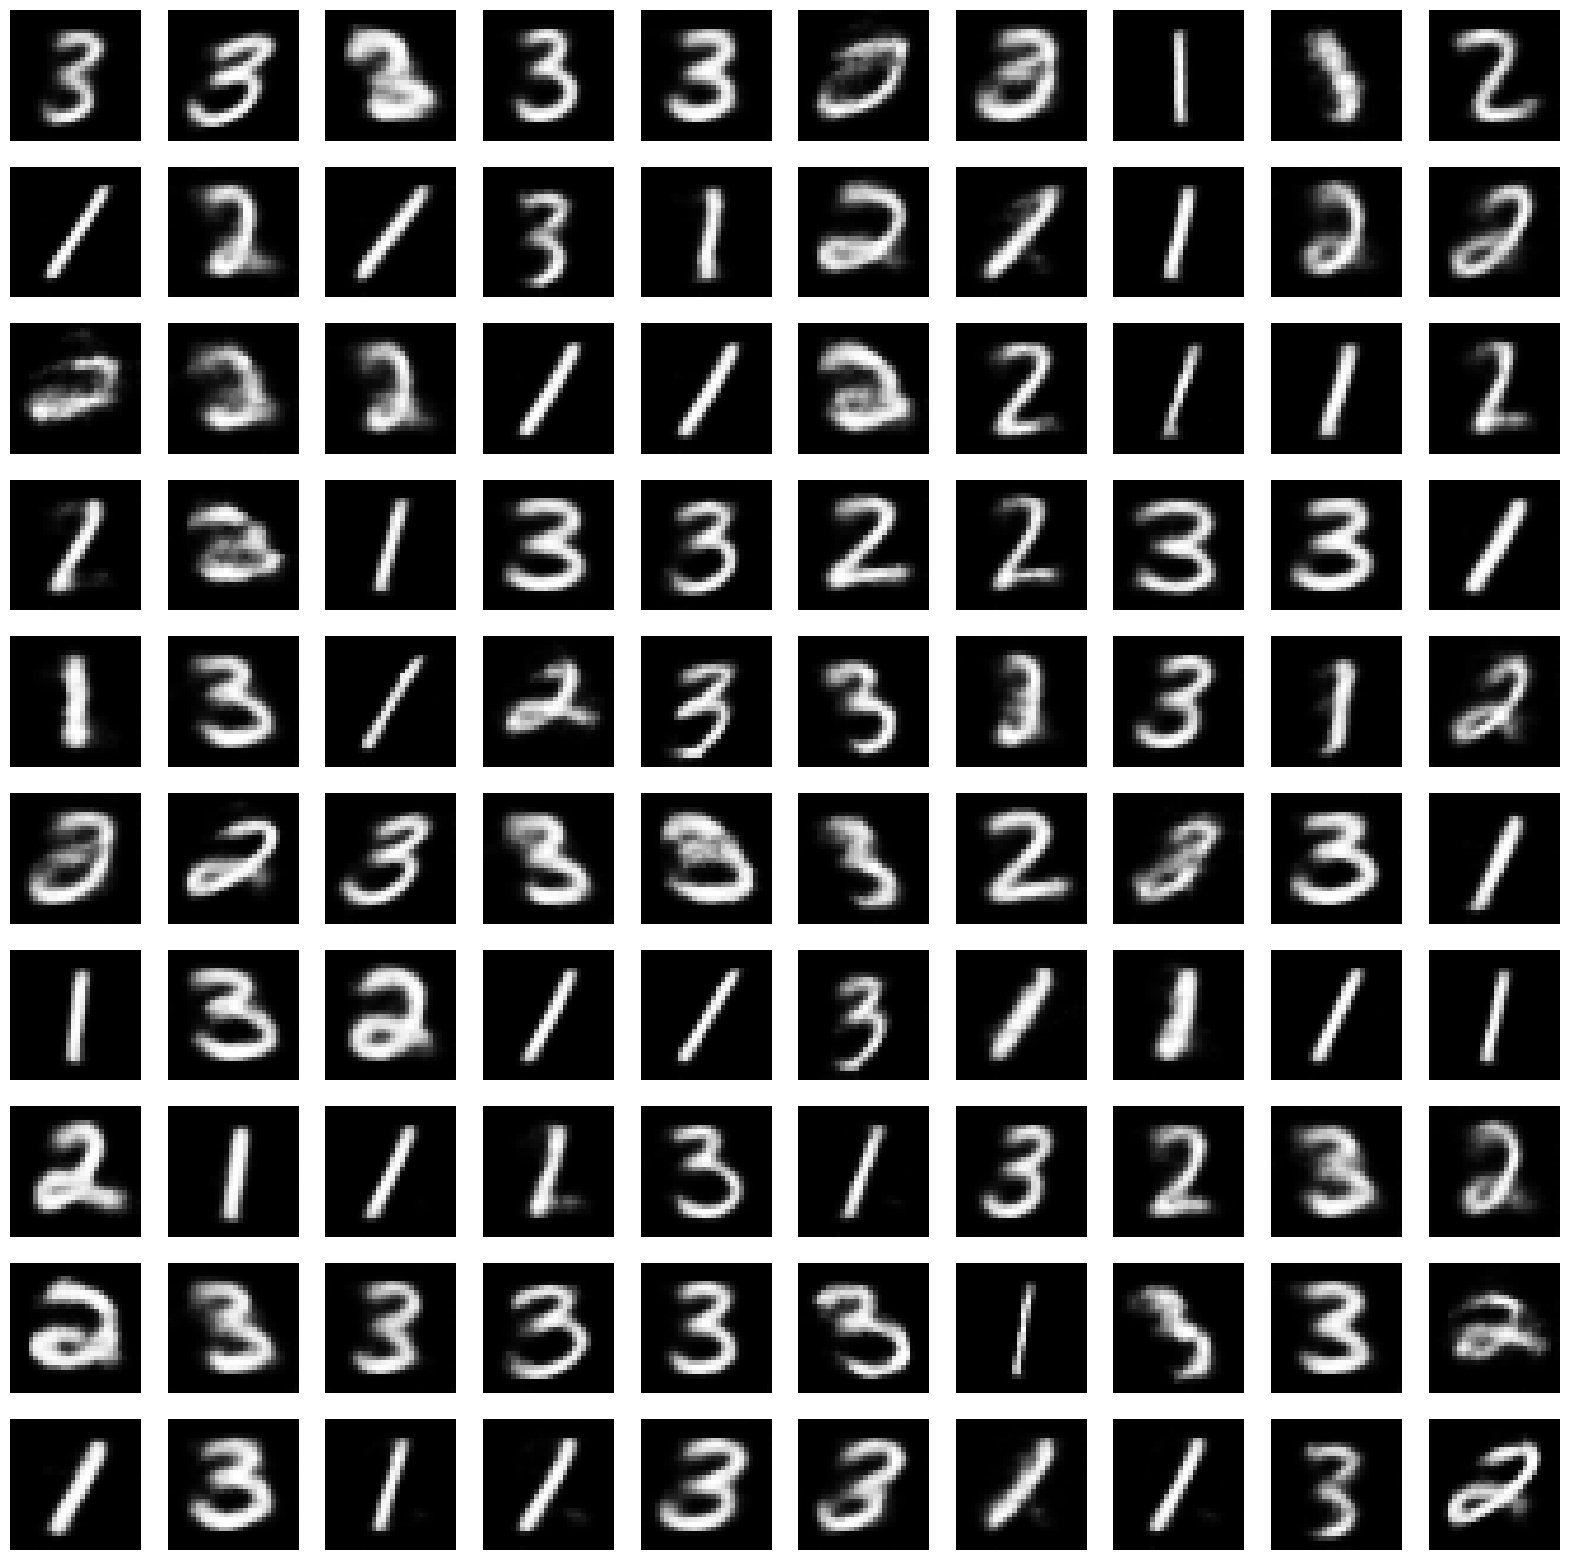

Epoch:   153/800 - Loss: 24.6513 - Recon Loss: 17.8375 - KL Loss: 6.8138:  96%|█████████▋| 27/28 [00:17<00:00, 120.55it/s]

In [99]:
model.eval()
recons = model.sample(100)
recons = recons.cpu().detach().numpy().reshape(100, 28, 28)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

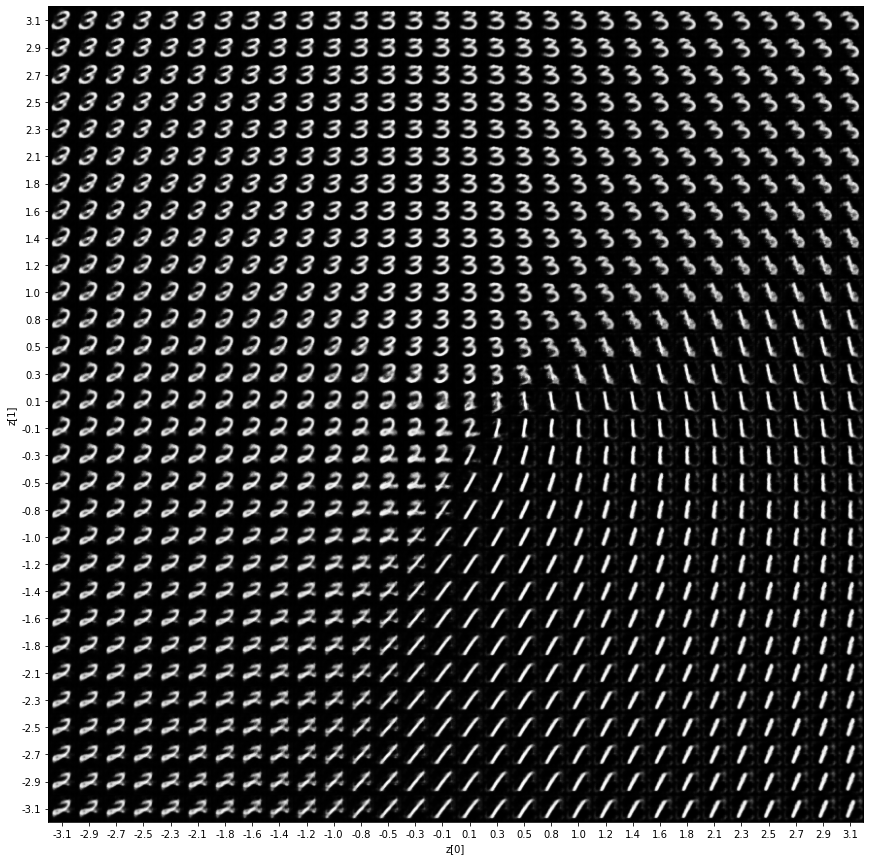

In [6]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    
    grid_x = torch.linspace(- np.pi , np.pi, n).to(device)
    grid_y = torch.linspace(np.pi, -np.pi, n).to(device)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.stack([xi, yi]).to(device)
            x_decoded = vae.decode(z_sample.unsqueeze(0), None)
            digit = x_decoded.reshape(digit_size, digit_size).cpu().detach().numpy()
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x.detach().cpu().numpy(), 1)
    sample_range_y = np.round(grid_y.detach().cpu().numpy(), 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

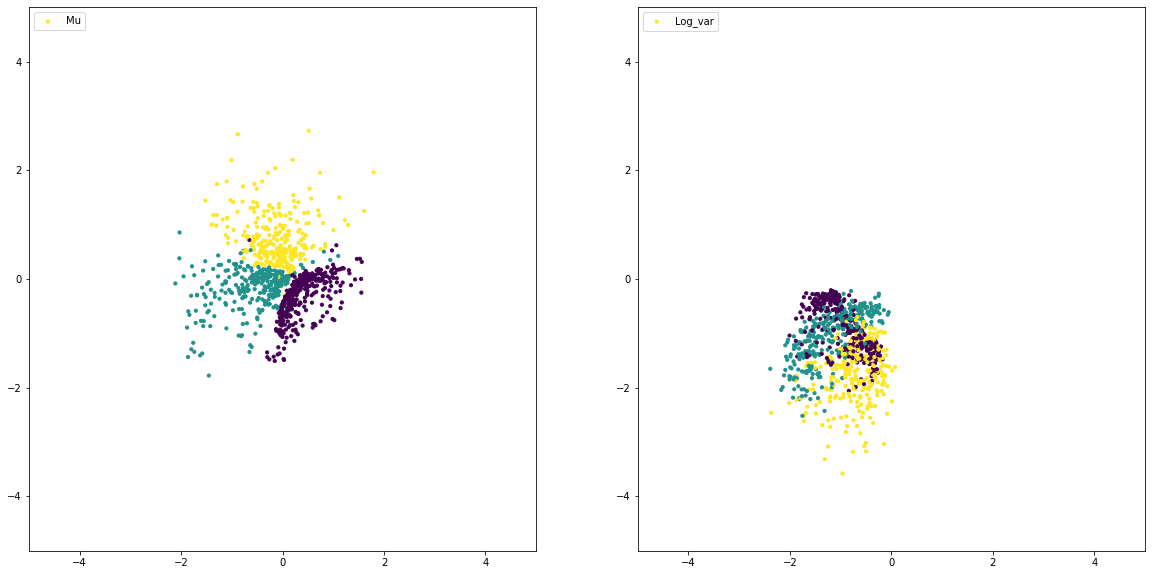

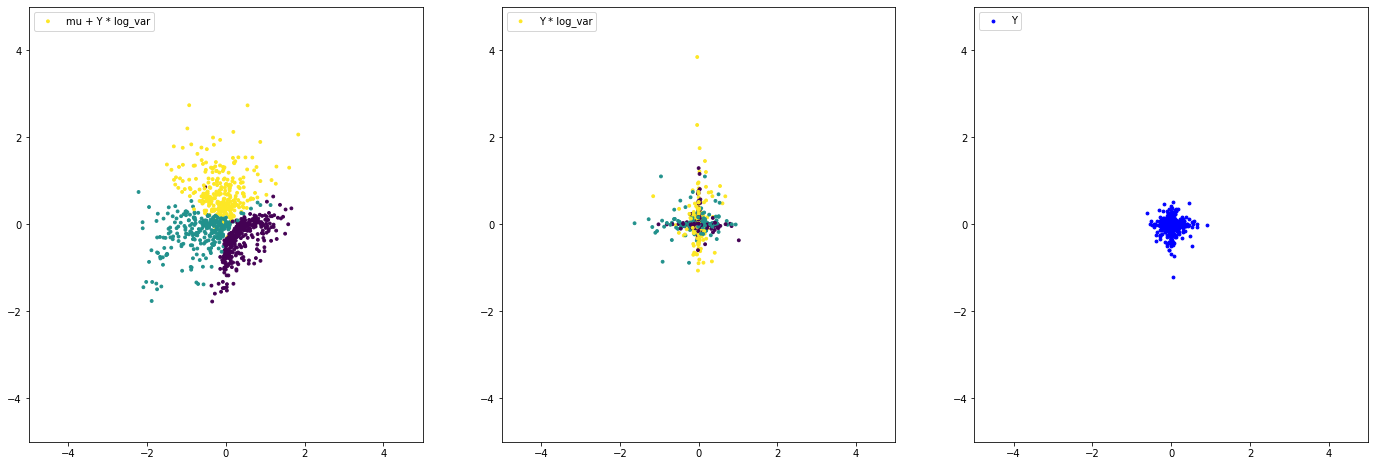

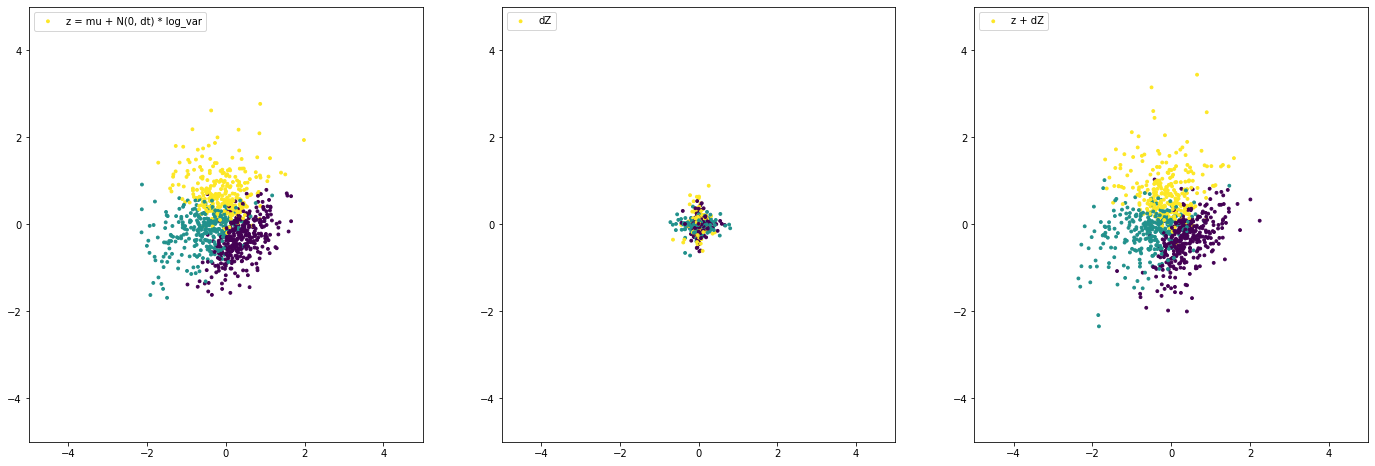

In [7]:
_, z_space, _, mu, log_var, _ = model.forward(train_x.to(device))
# Y = model.brownian_manifold_step(mu, model.dt)
Y = model.hyperboloide_normal_sample(mu, model.dt)
eps = log_var * Y

plt.figure(figsize=(20, 10))
for i, (var, name) in enumerate(zip([mu, log_var], ['Mu', 'Log_var'])):
    plt.subplot(1, 2, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=10, label=name, c=train_y)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(24, 8))
for i, (var, name) in enumerate(zip([z_space, eps, Y], ['mu + Y * log_var', 'Y * log_var', 'Y'])):
    plt.subplot(1, 3, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=8, label=name, c=('b' if name == 'Y' else train_y))
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()

normal_z_space = mu + torch.normal(0, np.sqrt(model.dt), size=mu.shape).to(device) * torch.exp(log_var * 0.5)
z = normal_z_space.clone()
dZ = model.hyperboloide_normal_sample(z, model.dt)
z = z + dZ

plt.figure(figsize=(24, 8))
for i, (var, name) in enumerate(zip([normal_z_space, dZ, z], ['z = mu + N(0, dt) * log_var', 'dZ', 'z + dZ'])):
    plt.subplot(1, 3, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=8, label=name, c=train_y)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()

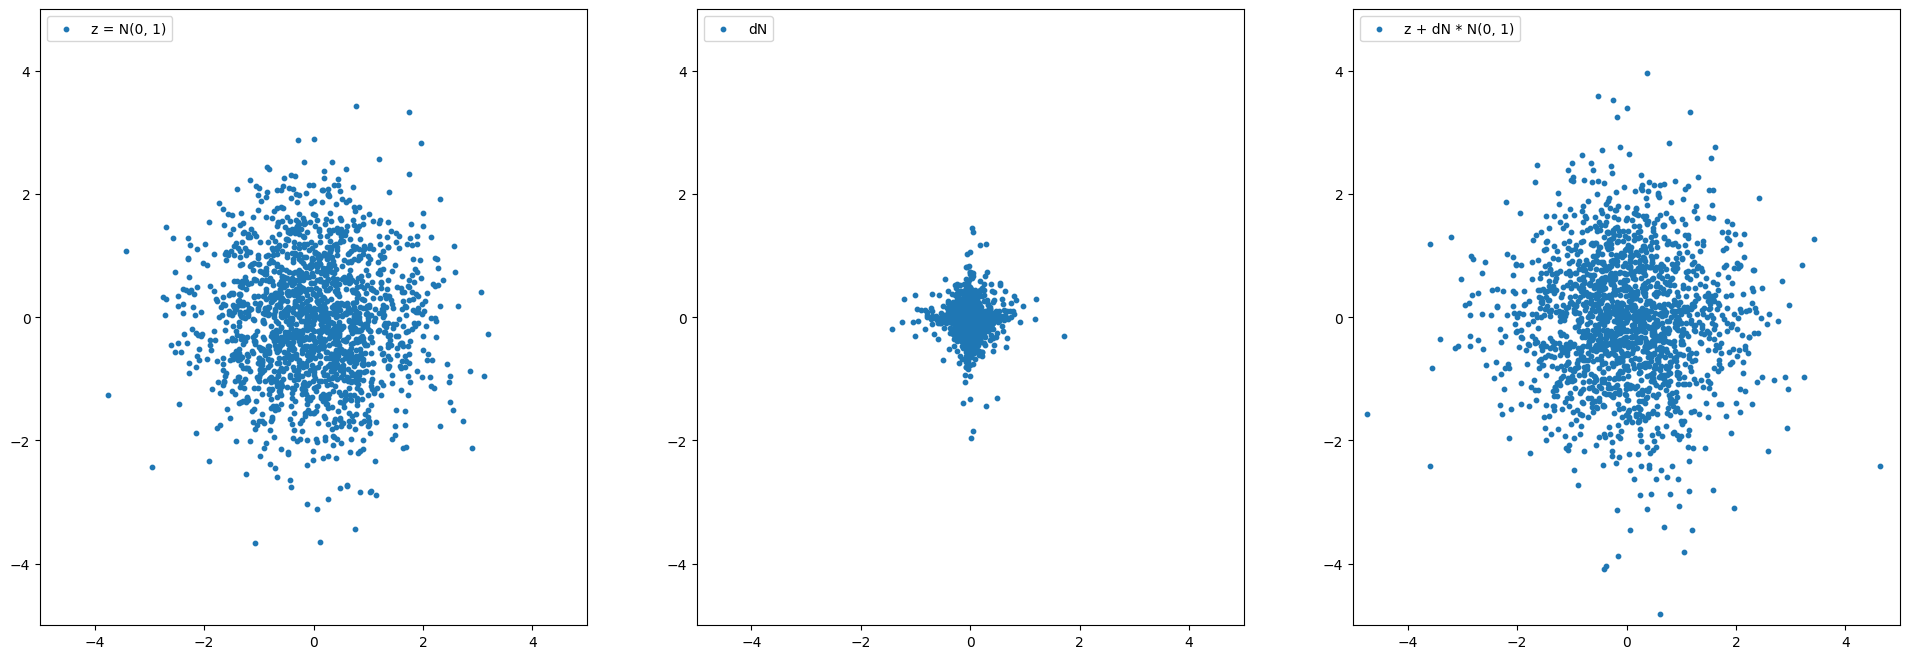

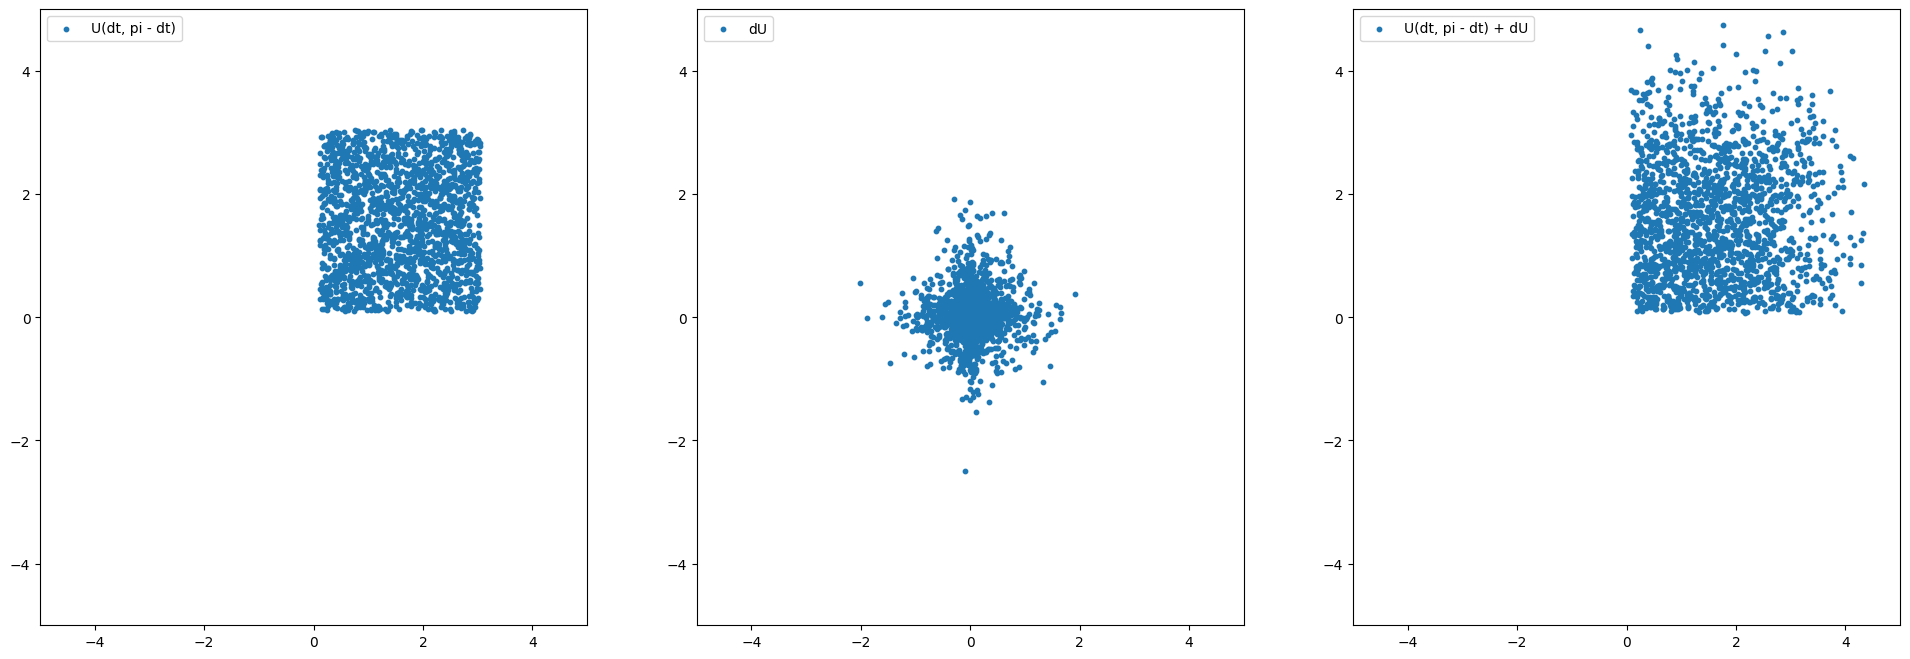

In [187]:
noise = torch.normal(mean=0, std=1, size=(mu.shape[0], 2)).to(device)
N = noise.clone()
dN = model.hyperboloide_normal_sample(N, model.dt)
N = N + dN

plt.figure(figsize=(24, 8))
for i, (var, name) in enumerate(zip([noise, dN, N], ['z = N(0, 1)', 'dN', 'z + dN * N(0, 1)'])):
    plt.subplot(1, 3, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=10, label=name)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()

noise = torch.FloatTensor(mu.shape[0], 2).uniform_(model.dt, np.pi - model.dt).to(device)
U = noise.clone()
dU = model.hyperboloide_normal_sample(U, model.dt)
U = U + dU

plt.figure(figsize=(24, 8))
for i, (var, name) in enumerate(zip([noise, dU, U], ['U(dt, pi - dt)', 'dU', 'U(dt, pi - dt) + dU'])):
    plt.subplot(1, 3, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=10, label=name)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()